# Look at the bottom pressure recorder data

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from s3fs import S3FileSystem, S3Map

import cmocean as cm

In [2]:
# %matplotlib notebook

In [3]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'


In [4]:
# ds = xr.open_dataset('../DATA/[BB23]_[BB23_REC]_[W310]_[48]_[RBRquartz TP]_[213895]_[no_outfile_append].nc')
# sitename = 'L245'
# ds = xr.open_dataset('../DATA/FV01/RBRqu/[BB23]_[BB23_REC]_[L245]_[33]_[RBRquartz TP]_[213897]_[no_outfile_append].nc')

sitename = 'W310'
ds = xr.open_dataset('../../../SWOT_Cruise/FV01/RBRqu/[BB23]_[BB23_REC]_[W310]_[48]_[RBRquartz TP]_[213895]_[no_outfile_append].nc')

# ds_1Hz = ds.isel(time=slice(None,None,16)).sel(time=slice('2023-04-22 00:00:00','2023-06-01 00:00:00'))
ds_1Hz = ds.isel(time=slice(None,None,16)).sel(time=slice('2023-04-18 00:00:00','2023-04-22 00:00:00'))

In [11]:
ds_1Hz

<xarray.Dataset>
Dimensions:          (time: 85945)
Coordinates:
  * time             (time) datetime64[ns] 2023-04-21T00:06:20.750000 ... 202...
    lat_nom          float64 ...
    lon_nom          float64 ...
    z_nom            float64 ...
Data variables:
    BPR_Pressure     (time) float64 ...
    Temperature      (time) float64 ...
    BPR_Temperature  (time) float64 ...
    qc_Temperature   (time) float64 ...
    qc_Pressure      (time) float64 ...
Attributes: (12/35)
    title:                           Measured data from an RBR Data Logger
    institution:                     The University of Western Australia
    institution_division:            Ocean Dynamics
    source:                          RBR Data Logger
    project:                         BB23
    history:                         
    ...                              ...
    nominal_instrument_height_asb:   0.48
    nominal_instrument_orientation:  
    timezone:                        UTC
    process_level:                   1
    is_profile_data:                 0
    pimos_nickname:                  RBRqu

Text(0, 0.5, 'Temperature')

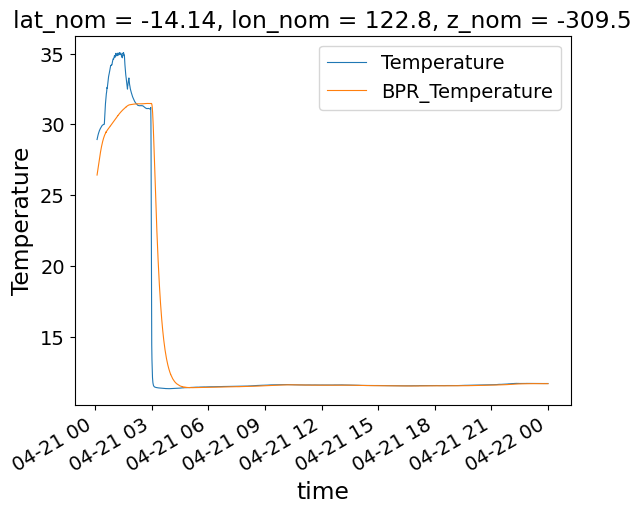

In [14]:
plt.figure()
ds_1Hz['Temperature'].plot(lw=0.8, label='Temperature')
ds_1Hz['BPR_Temperature'].plot(lw=0.8, label='BPR_Temperature')
plt.legend()
plt.ylabel('Temperature')

Text(0, 0.5, 'Pressure [dbar]')

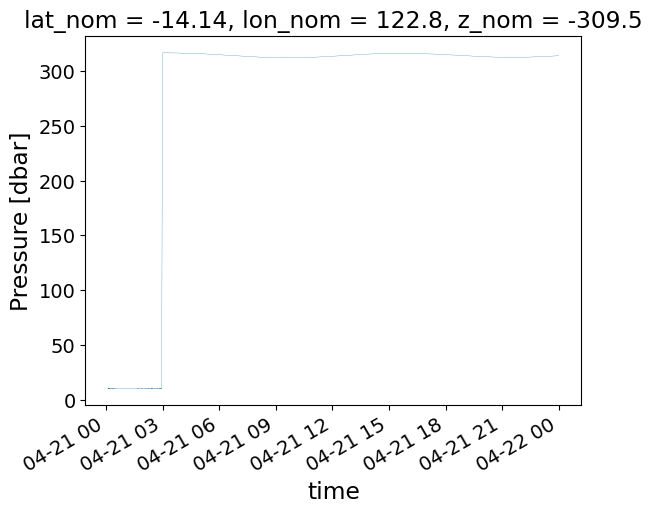

In [5]:
plt.figure()
ds_1Hz['BPR_Pressure'].plot(lw=0.2)
plt.ylabel('Pressure [dbar]')

In [8]:
from utils import filt_decompose

In [9]:
time = ds_1Hz.time.values
dt = (time[1:]-time[:-1]).mean()
dtsec = dt.astype(float)*1e-9
dtsec, 1/dtsec

(1.0, 1.0)

In [12]:
ypr = ds_1Hz['BPR_Pressure']-ds_1Hz['BPR_Pressure'].mean()
yf = filt_decompose(ypr, dtsec)


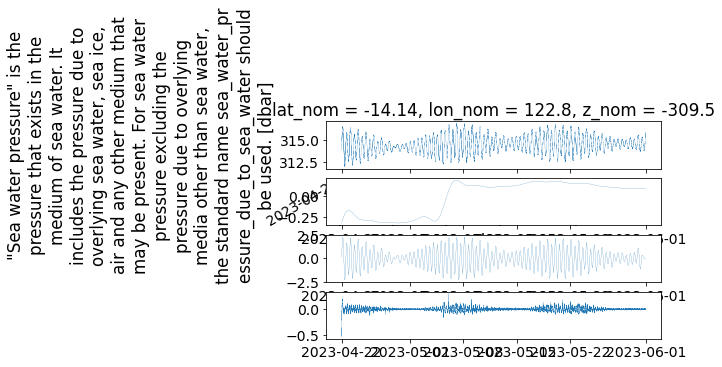

In [13]:
plt.figure()

ax0 = plt.subplot(411)
ds_1Hz['BPR_Pressure'].plot(lw=0.2)

ax1 = plt.subplot(412,sharex=ax0)
plt.plot(time, yf[:,0], lw=0.2)

ax2 = plt.subplot(413,sharex=ax0)
plt.plot(time, yf[:,1], lw=0.2)

ax3 = plt.subplot(414, sharex=ax0)
plt.plot(time, yf[:,2], lw=0.2)



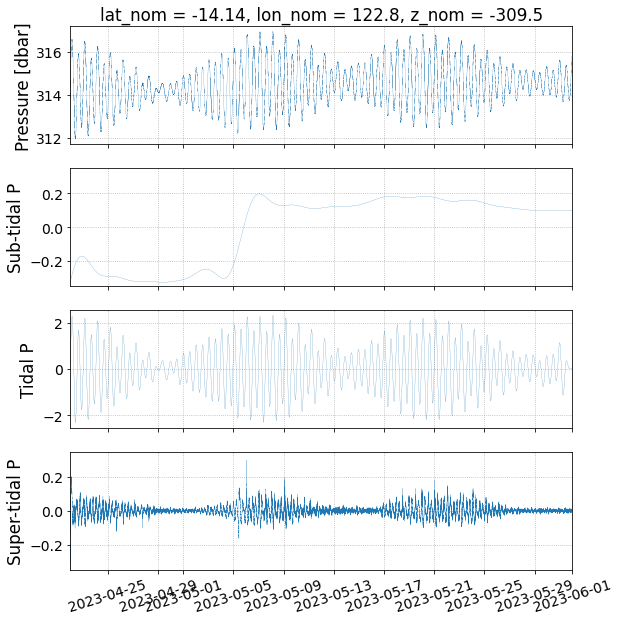

In [14]:
plt.figure(figsize=(9,10))

ax0 = plt.subplot(411)
ds_1Hz['BPR_Pressure'].plot(lw=0.2)
ax0.set_xticklabels([])
ax0.set_xlim(time[0],time[-1])
ax0.set_ylabel('Pressure [dbar]')
ax0.set_xlabel('')
plt.grid(b=True, ls=':')

ax1 = plt.subplot(412)
plt.plot(time, yf[:,0], lw=0.2)
ax1.set_xticklabels([])
ax1.set_ylim(-0.35, 0.35)
ax1.set_xlim(time[0],time[-1])
ax1.set_ylabel('Sub-tidal P')
plt.grid(b=True, ls=':')

ax2 = plt.subplot(413)
plt.plot(time, yf[:,1], lw=0.2)
ax2.set_xticklabels([])
ax3.set_ylim(-2.5, 2.5)
ax2.set_xlim(time[0],time[-1])
ax2.set_ylabel('Tidal P')
plt.grid(b=True, ls=':')

ax3 = plt.subplot(414)
plt.plot(time, yf[:,2], lw=0.2)
# ax3.set_xticklabels([])
ax3.set_ylim(-0.35, 0.35)
plt.xticks(rotation=17)
ax3.set_xlim(time[0],time[-1])
ax3.set_ylabel('Super-tidal P')
plt.grid(b=True, ls=':')

plt.savefig('../FIGURES/BPR_{}_filtered.png'.format(sitename), dpi=150)

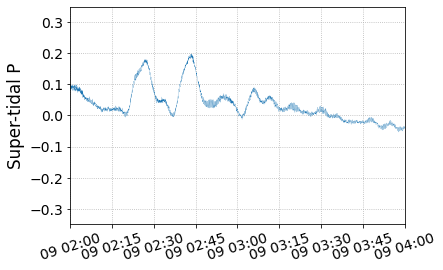

In [15]:
t1,t2 = np.datetime64('2023-05-09 02:00:00'),np.datetime64('2023-05-09 04:00:00')
plt.figure()
ax3=plt.subplot(111)
plt.plot(time, yf[:,2], lw=0.2)
# ax3.set_xticklabels([])
ax3.set_ylim(-0.35, 0.35)
plt.xticks(rotation=17)
ax3.set_xlim(t1,t2)
ax3.set_ylabel('Super-tidal P')
plt.grid(b=True, ls=':')
plt.savefig('../FIGURES/BPR_{}_highfreq_soliton.png'.format(sitename), dpi=150)

In [16]:
import speccy

In [19]:
f, I = speccy.periodogram(ypr, dtsec/86400)
# f, I = speccy.periodogram(ypr, 1/16.)

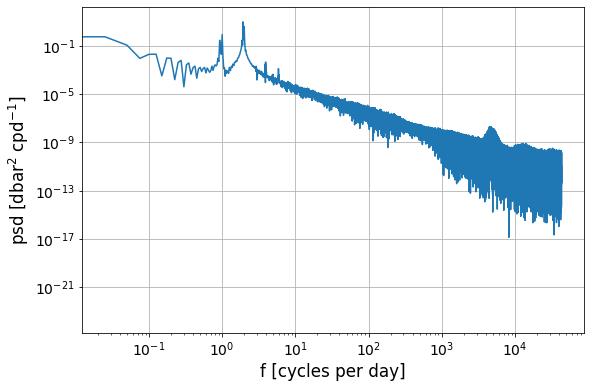

In [20]:
plt.figure(figsize=(9,6))
plt.loglog(f, I)
plt.grid(b=True)
# plt.ylim(1e-16, 1e2)
plt.ylabel('psd [dbar$^2$ cpd$^{-1}$]')
plt.xlabel('f [cycles per day]')
plt.savefig('../FIGURES/BPR_{}_speccy.png'.format(sitename), dpi=150)

In [ ]:
86400/30